#### Preliminaries - import main libraries

In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature
from skimage import color, io, exposure, feature
from skimage import transform as tf
from skimage.morphology import disk, diamond, square, opening, dilation, erosion, closing, convex_hull_image
from skimage.morphology import remove_small_objects
from skimage.filters import  threshold_adaptive, threshold_otsu

from skimage.feature import corner_fast, corner_peaks, corner_orientations
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon

%matplotlib inline

#### Import test image

In [11]:
# import from url
#url = 'https://github.com/mycarta/rainbowbot/raw/master/test_f3_distorted_tet.ong'
#img = np.asarray(io.imread(url))[:,:,:3] # with removing alpha channel
img = np.asarray(io.imread('test images new/Zoback_2-17b.jpg'))[:,:,:3]

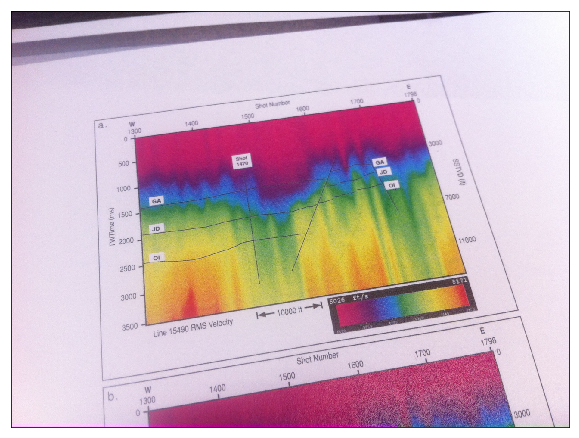

In [12]:
# plot it
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(img,  interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('input.png', dpi=400, bbox_inches='tight', pad_inches=0) 


#### Preporcessing

In [20]:
# Hystogram equalization
gry = color.rgb2gray(img)
rescale = exposure.equalize_adapthist(gry, clip_limit = 0.01)

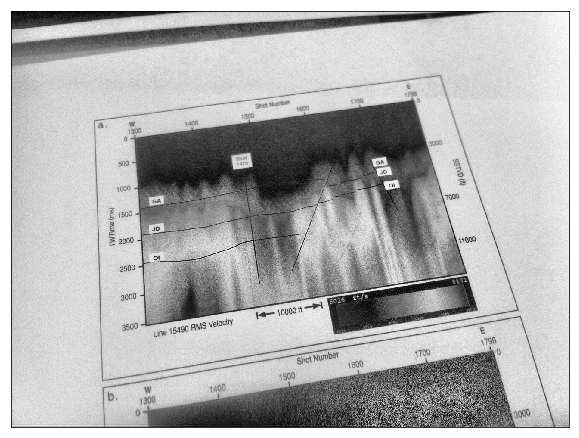

In [21]:
# plot it
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(rescale,  interpolation = 'none', cmap = 'gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('input.png', dpi=400, bbox_inches='tight', pad_inches=0) 

#### Convert to binary 

In [22]:
binary = np.logical_and(color.rgb2gray(rescale) > 0.03, color.rgb2gray(rescale) < 0.97)

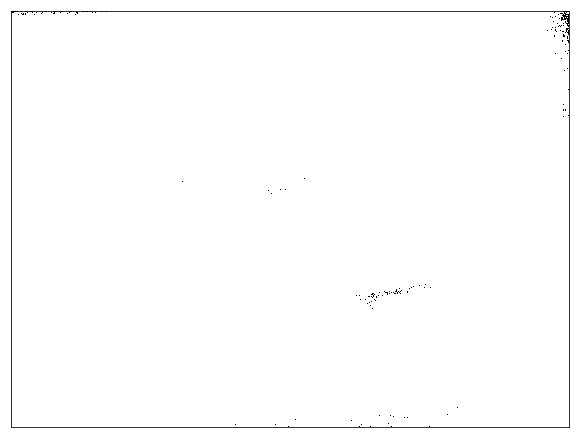

In [23]:
# plot it
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary,  interpolation = 'none', cmap = 'gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('input.png', dpi=400, bbox_inches='tight', pad_inches=0) 

In [ ]:
# Contrast stretching
gry = color.rgb2gray(img)
p2, p98 = np.percentile(gry, (2, 98))
rescale = exposure.rescale_intensity(gry, in_range=(p2, p98))

from skimage.filters.rank import otsu

radius = 5
selem = disk(radius)

# t_loc_otsu is an image
t_loc_otsu = otsu(rescale, selem)
loc_otsu = rescale >= t_loc_otsu


In [ ]:
# plot it
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(loc_otsu,  interpolation = 'none', cmap = 'gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('input.png', dpi=400, bbox_inches='tight', pad_inches=0) 

#### Get largest element in the binary image

Detect largest bright element in the binary image. Making the assumption it would be the map.
Eliminate everything else (text, colorbar, holes, etc.).

In [ ]:
# Label all white objects (made up of ones)
label_objects, nb_labels = ndi.label(binary_global) # ndimage.label actually labels 0 (background) as 0 and then 
                                                    # labels every nonzero object as 1, 2, ... n. 
    
# Calculate every labeled object's size. 
# np.bincount ignores whether input is an image or another type of array.
# It just calculates the binary sizes, including for the 0 (background).
sizes = np.bincount(label_objects.ravel())   

sizes[0] = 0    # This sets the size of the background to 0 so that if it happened to be larger than 
                # the largest white object it would not matter

# Keep only largest object
binary_objects = remove_small_objects(binary_global, max(sizes)) 

In [ ]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary_objects, cmap='gray',  interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('onlylargest.png', dpi=400, bbox_inches='tight', pad_inches=0) 

In [ ]:
# Remove holes from it (black regions inside white object)
binary_holes = ndi.morphology.binary_fill_holes(binary_objects) 

In [ ]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary_holes, cmap='gray', interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#fig.savefig('noholes.png', dpi=400, bbox_inches='tight', pad_inches=0) 

In [ ]:
enhanced = opening(binary_holes, disk(15))

In [ ]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(enhanced, cmap='gray', interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#fig.savefig('noholes.png', dpi=400, bbox_inches='tight', pad_inches=0) 

#### Find contour, approximate it with a quadrilateral, find and sort corners

In [ ]:
# test
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(enhanced, cmap='gray', interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

for contour in find_contours(enhanced, 0):
    coords = approximate_polygon(contour, tolerance=1000)
    ax.plot(coords[:, 1], coords[:, 0], '-r', linewidth=2)
plt.show()

In [ ]:
contour = np.squeeze(find_contours(enhanced, 0))
coords = approximate_polygon(contour, tolerance=1000)
coords

In [ ]:
# Function to sort corners based on angle from centroid
# modified from: http://stackoverflow.com/a/31235064/1034648
def ordered(points):
    x = points[:,0]
    y = points[:,1]
    cx = np.mean(x)
    cy = np.mean(y)
    a = np.arctan2(y - cy, x - cx)
    order = a.ravel().argsort()
    x = x[order]
    y = y[order]
    return np.vstack([x,y])

In [ ]:
# sort the corners
# except the last one in the contour (repeatition of first point)
sortedCoords = ordered(coords[:-1]).T

# if we wanted to re-add it, by the way, we would do this
#sortedCoords =  np.concatenate([sortedCoords, sortedCoords[:1,:]], axis = 0) 
sortedCoords

In [ ]:
# just making sure points are indeed sorted

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(enhanced, cmap='gray', interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

ax.scatter(sortedCoords[:, 1], sortedCoords[:, 0], s=60, color=['magenta', 'cyan', 'orange', 'green'])
plt.show()

### Nicely sorted counter-clocwise!!

#### Define size of output image based on largest width and height of input, and define destination coordinates for registration

In [ ]:
w1 = np.sqrt(((sortedCoords[0, 1]-sortedCoords[3, 1])**2)+((sortedCoords[0, 0]-sortedCoords[3, 0])**2))
w2 = np.sqrt(((sortedCoords[1, 1]-sortedCoords[2, 1])**2)+((sortedCoords[1, 0]-sortedCoords[2, 0])**2))

h1 = np.sqrt(((sortedCoords[0, 1]-sortedCoords[1, 1])**2)+((sortedCoords[0, 0]-sortedCoords[1, 0])**2))
h2 = np.sqrt(((sortedCoords[3, 1]-sortedCoords[2, 1])**2)+((sortedCoords[3, 0]-sortedCoords[2, 0])**2))

w = max(int(w1), int(w2))
h = max(int(h1), int(h2))

print h,w

In [ ]:
dst = np.array([
        [0, 0],
        [h-1, 0],
        [h-1, w-1],
        [0, w-1]], dtype = 'float32')
dst

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(dst[:, 1], dst[:, 0], s=60, color=['magenta', 'cyan', 'orange', 'green'])
plt.axis('equal')
plt.gca().invert_yaxis()
plt.show()

#### Rectify image by warping using homologous/corresponding points 

In [ ]:
dst[:,[0,1]] = dst[:,[1,0]]
sortedCoords[:,[0,1]] = sortedCoords[:,[1,0]]

In [ ]:
tform = tf.ProjectiveTransform()
tform.estimate(dst,sortedCoords)

In [ ]:
warped = tf.warp(img, tform, output_shape=(h-1, w-1))

fig, ax = plt.subplots(nrows=2, figsize=(20, 10))


ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])
ax[0].plot(sortedCoords[:, 0], sortedCoords[:, 1], '.r')

ax[1].imshow(warped, cmap=plt.cm.gray)
ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])

In [ ]:
np.save('temp', warped)

### Can restart here

In [ ]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature
from skimage import color, io, exposure, feature
from skimage import transform as tf
from skimage.morphology import disk, diamond, square, opening, dilation, erosion, closing, convex_hull_image
from skimage.morphology import remove_small_objects
from skimage.filters import  threshold_adaptive, threshold_otsu

from skimage.feature import corner_fast, corner_peaks, corner_orientations
from skimage.measure import find_contours, approximate_polygon

%matplotlib inline

#### Find rectangular contours and use to make a mask for inpainting

In [ ]:
warped = color.rgb2gray(np.load('temp.npy'))
blr = sp.signal.medfilt2d(color.rgb2gray(warped), 5)

#### Preprocessing

In [ ]:
#blr = sp.ndimage.filters.gaussian_filter(color.rgb2gray(warped),3) 
#blr = sp.signal.medfilt2d(color.rgb2gray(warped), 3)

#blr = sp.ndimage.filters.gaussian_filter(color.rgb2gray(warped),3) 
#blr = sp.signal.medfilt2d(color.rgb2gray(blr), 3)

#### Canny edge detection and enhancement

In [ ]:
from image_source_canny import canny
from mycarta_im_functions import auto_canny

In [ ]:
cn = auto_canny(warped) # try also a tight canny

In [ ]:
# plot it
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(cn, interpolation = 'none', cmap = 'gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('input.png', dpi=400, bbox_inches='tight', pad_inches=0) 

In [ ]:
cny_dilated = dilation(cn, disk(2.5))

In [ ]:
# plot it
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(cny_dilated, interpolation = 'none', cmap = 'gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('input.png', dpi=400, bbox_inches='tight', pad_inches=0) 

#### We want to find contours from canny and only keep those that are rectangles

#### First test just using number of points in the contour

In [ ]:
# test
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(cny_dilated, cmap='gray', interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

for contour in find_contours(cny_dilated, 0):
    coords = approximate_polygon(contour, tolerance=30)
    if len(coords) == 5:
        ax.plot(coords[:, 1], coords[:, 0], '-r', linewidth=2)
plt.show()

#### It looks like this is not enough. We will use also disstances from centroid; we will impose they be very similar

In [ ]:
# Function to sort corners based on angle from centroid
# modified from: http://stackoverflow.com/a/31235064/1034648
def ordered(points):
    x = points[:,0]
    y = points[:,1]
    cx = np.mean(x)
    cy = np.mean(y)
    a = np.arctan2(y - cy, x - cx)
    order = a.ravel().argsort()
    x = x[order]
    y = y[order]
    return np.vstack([x,y])

In [ ]:
# Function to test if 4 points form a rectangle
# adapted to Python from:
# http://stackoverflow.com/questions/2303278/find-if-4-points-on-a-plane-form-a-rectangle/2304031#2304031
def isRectangle(points):
    x = points[:,0]
    y = points[:,1]
    cx = np.mean(x)
    cy = np.mean(y)
    dd1 = abs(cx-x[0]) + abs(cy-y[0])
    dd2 = abs(cx-x[1]) + abs(cy-y[1])
    dd3 = abs(cx-x[2]) + abs(cy-y[2])
    dd4 = abs(cx-x[3]) + abs(cy-y[3])
    return abs(dd1-dd2)<=10 and abs(dd1-dd3)<=10 and abs(dd1-dd4)<=10


### A better alternative may be to use angles between those segments connecting centroid with 4 corners. Sorted again as below.      
### To be tested but the idea is: for each corner, take the same absolute value of the x and y distances from centroid as above; in this case these are the coordinates of a new point. Next use the function *angle_wrt_x* below to get the angle between this new point and the origin 0, 0 with respect to the positive x-axis. Sum the 1st with 2nd and 3rd with 4th: those sums should be equal to within some very small angle.

In [ ]:
# test
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(cny_dilated, cmap='gray', interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

for contour in find_contours(cny_dilated, 0):
    coords = approximate_polygon(contour, tolerance=30)
    if len(coords) == 5 and isRectangle(ordered(coords[:-1]).T):
        ax.plot(coords[:, 1], coords[:, 0], '-r', linewidth=2)
        
plt.show()

In [ ]:
from skimage.draw import polygon
mask = np.zeros(np.shape(cny_dilated), dtype=np.uint8)
for contour in find_contours(cny_dilated, 0):
    coords = approximate_polygon(contour, tolerance=30)
    if len(coords) == 5 and isRectangle(ordered(coords[:-1]).T):
        #print coords
        #print ordered(coords[:-1])
        rr,cc = polygon(ordered(coords[:-1])[0], ordered(coords[:-1])[1])
        mask[rr,cc]=1

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(mask, cmap='gray', interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
        
plt.show()

In [ ]:
dmask = dilation(mask, square(10))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(dmask, cmap='gray', interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
        
plt.show()

In [ ]:
img = np.load('temp.npy')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(img, interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
        
plt.show()

In [ ]:
np.shape(img)

In [ ]:
image_defect = img.copy()
for layer in range(image_defect.shape[-1]):
    image_defect[np.where(dmask)] = 0

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(image_defect, interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
        
plt.show()

In [ ]:
from skimage.restoration import inpaint

result = inpaint.inpaint_biharmonic(image_defect, dmask, multichannel = True)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(result, interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
        
plt.show()